In [1]:
import torch
import torch.nn.functional as F
import matplotlib.pyplot as plt
%matplotlib inline

In [2]:
# read in all the words
words = open('names.txt', 'r').read().splitlines()
print(words[:8])
print(len(words))

['emma', 'olivia', 'ava', 'isabella', 'sophia', 'charlotte', 'mia', 'amelia']
32033


In [3]:
# Build the vocabulary
chars = sorted(list(set(''.join(words))))
stoi = {s:i+1 for i,s in enumerate(chars)}
stoi['.'] = 0
itos = {i:s for s,i in stoi.items()}

vocab_size = len(stoi)

print ( itos )

{1: 'a', 2: 'b', 3: 'c', 4: 'd', 5: 'e', 6: 'f', 7: 'g', 8: 'h', 9: 'i', 10: 'j', 11: 'k', 12: 'l', 13: 'm', 14: 'n', 15: 'o', 16: 'p', 17: 'q', 18: 'r', 19: 's', 20: 't', 21: 'u', 22: 'v', 23: 'w', 24: 'x', 25: 'y', 26: 'z', 0: '.'}


In [4]:
# Build the dataset
block_size = 3

def build_dataset(words):
    X,Y = [], []
    for w in words:
        context = [0] * block_size
        for ch in w + '.':
            ix = stoi[ch]
            X.append(context)
            Y.append(ix)
            context = context[1:] + [ix]

    X = torch.tensor(X)
    Y = torch.tensor(Y)
    print(X.shape, Y.shape)
    return X, Y

import random
random.seed(42)
random.shuffle(words)
n1 = int(0.8*len(words))
n2 = int(0.9*len(words))

Xtr,Ytr = build_dataset(words[:n1])
Xdev,Ydev = build_dataset(words[n1:n2])
Xte,Yte = build_dataset(words[n2:])

torch.Size([182625, 3]) torch.Size([182625])
torch.Size([22655, 3]) torch.Size([22655])
torch.Size([22866, 3]) torch.Size([22866])


In [5]:
# Init the parameters

n_embed = 10
n_hidden = 200

g = torch.Generator().manual_seed(2147483647)
C = torch.randn((vocab_size,n_embed), generator=g)
W1 = torch.rand((n_embed*block_size,n_hidden), generator=g) * (5/3) / ((n_embed*block_size)**0.5)
b1 = torch.randn((n_hidden), generator=g) * 0.01
W2 = torch.randn((n_hidden,vocab_size), generator=g) * (5/3) / ((n_hidden)**0.5)
b2 = torch.randn(vocab_size, generator=g) * 0
parameters = [C, W1, b1, W2, b2]

for p in parameters:
    p.requires_grad = True
    
sum(p.nelement() for p in parameters)

11897

In [6]:
# Forward pass
losses = []
steps = []
batch_size = 32
max_steps = 200000
for i in range(max_steps):
    
    ix = torch.randint(0,Xtr.shape[0],(batch_size,))
    Xb,Yb = Xtr[ix], Ytr[ix]

    emb = C[Xb]
    embcat = emb.view(emb.shape[0], -1)
    hpreact = embcat @ W1 + b1
    h = torch.tanh(hpreact)
    logits = h @ W2 + b2
    loss = F.cross_entropy( logits, Ytr[ix] )

    # Backwards pass
    for p in parameters:
        p.grad = None 
    loss.backward()

    ## Update
    lr = 0.1 if i < 100000 else 0.01
    for p in parameters:
        p.data += -lr * p.grad
    
    losses.append(loss.log10().item())
    steps.append(i)
    
    if i % 10000 == 0:
        print ( f'{i:7d}/{max_steps:7d}: {loss.item():0.4f}' )

      0/ 200000: 3.6343
  10000/ 200000: 2.3018
  20000/ 200000: 2.2563
  30000/ 200000: 2.1972
  40000/ 200000: 2.3443
  50000/ 200000: 2.1316
  60000/ 200000: 2.1765
  70000/ 200000: 1.9362
  80000/ 200000: 2.4566
  90000/ 200000: 2.2765
 100000/ 200000: 2.1204
 110000/ 200000: 1.7595
 120000/ 200000: 2.3580
 130000/ 200000: 2.0019
 140000/ 200000: 2.0288
 150000/ 200000: 1.7836
 160000/ 200000: 2.2312
 170000/ 200000: 1.8612
 180000/ 200000: 2.3834
 190000/ 200000: 2.0708


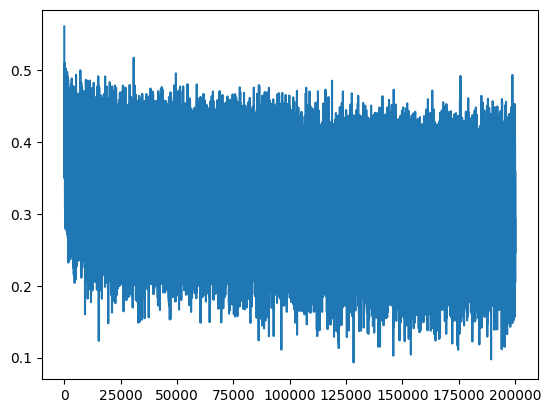

In [7]:
plt.plot( steps, losses )

In [8]:
# Print loss over all datasets
@torch.no_grad()
def split_loss( split ):
    X,Y = {
        'train': (Xtr,Ytr),
        'val': (Xdev,Ydev),
        'test': (Xte,Yte)
    }[split]
    
    emb = C[X]
    embcat = emb.view(emb.shape[0], -1)
    h = torch.tanh(embcat @ W1 + b1)
    logits = h @ W2 + b2
    loss = F.cross_entropy( logits, Y )
    print ( loss.item() )
    
split_loss( 'train' )
split_loss( 'val' )
split_loss( 'test' )

2.0439724922180176
2.1032211780548096
2.1071155071258545


In [9]:
g = torch.Generator().manual_seed(2147483647)
                                  
for _ in range(20):
    out = []
    context = [0] * block_size
    while True:
        emb = C[torch.tensor([context])]
        h = torch.tanh(emb.view(-1,30) @ W1 + b1)
        logits = h @ W2 + b2
        probs = F.softmax(logits, dim=1)
        ix = torch.multinomial(probs,num_samples=1,generator=g).item()
        context = context[1:] + [ix]
        out.append(ix)
        if ( ix == 0 ):
            break
    print( ''.join(itos[i] for i in out))
                  

junide.
jaycenz.
parfarie.
nai.
jirritolett.
juwe.
kalania.
yania.
vian.
dedaine.
imer.
sejaicayla.
ter.
noudmeryn.
demmere.
nastinormani.
core.
yarion.
kaesabi.
westoni.


In [10]:
# Init the parameters

n_embed = 10
n_hidden = 200

g = torch.Generator().manual_seed(2147483647)
C = torch.randn((vocab_size,n_embed), generator=g)
W1 = torch.rand((n_embed*block_size,n_hidden), generator=g) * (5/3) / ((n_embed*block_size)**0.5)
W2 = torch.randn((n_hidden,vocab_size), generator=g) * (5/3) / ((n_hidden)**0.5)
b2 = torch.randn(vocab_size, generator=g) * 0

bn_gain = torch.ones((1,n_hidden))
bn_bias = torch.zeros((1,n_hidden))

parameters = [C, W1, W2, b2, bn_gain, bn_bias]

bnmean_running = torch.zeros((1,n_hidden))
bnstd_running = torch.ones((1,n_hidden))

for p in parameters:
    p.requires_grad = True
    
sum(p.nelement() for p in parameters)

12097

In [11]:
# Forward pass
losses = []
steps = []
batch_size = 32
max_steps = 200000

for i in range(max_steps):
    
    ix = torch.randint(0,Xtr.shape[0],(batch_size,))
    Xb,Yb = Xtr[ix], Ytr[ix]

    emb = C[Xb]
    embcat = emb.view(emb.shape[0], -1)
    hpreact = embcat @ W1
    bnmeani = hpreact.mean(0, keepdim=True)
    bnstdi = hpreact.std(0, keepdim=True)    
    hpreact = bn_gain*(hpreact - bnmeani )/bnstdi + bn_bias
    
    with torch.no_grad():
        bnmean_running = 0.999 * bnmean_running + 0.001 * bnmeani
        bnstd_running = 0.999 * bnstd_running + 0.001 * bnstdi
    
    h = torch.tanh(hpreact)
    logits = h @ W2 + b2
    loss = F.cross_entropy( logits, Ytr[ix] )

    # Backwards pass
    for p in parameters:
        p.grad = None 
    loss.backward()

    ## Update
    lr = 0.1 if i < 100000 else 0.01
    for p in parameters:
        p.data += -lr * p.grad
    
    losses.append(loss.log10().item())
    steps.append(i)
    
    if i % 10000 == 0:
        print ( f'{i:7d}/{max_steps:7d}: {loss.item():0.4f}' )

      0/ 200000: 3.8062
  10000/ 200000: 1.9969
  20000/ 200000: 1.9556
  30000/ 200000: 2.2803
  40000/ 200000: 2.2252
  50000/ 200000: 2.1497
  60000/ 200000: 2.2471
  70000/ 200000: 2.4378
  80000/ 200000: 1.8191
  90000/ 200000: 2.4579
 100000/ 200000: 2.2132
 110000/ 200000: 1.8674
 120000/ 200000: 1.8746
 130000/ 200000: 2.1722
 140000/ 200000: 1.6638
 150000/ 200000: 2.5276
 160000/ 200000: 2.2393
 170000/ 200000: 2.2066
 180000/ 200000: 1.9423
 190000/ 200000: 2.1533


In [12]:
# Print loss over all datasets
@torch.no_grad()
def split_loss( split ):
    X,Y = {
        'train': (Xtr,Ytr),
        'val': (Xdev,Ydev),
        'test': (Xte,Yte)
    }[split]
    
    emb = C[X]
    embcat = emb.view(emb.shape[0], -1)
    hpreact = embcat @ W1 + b1
    hpreact = bn_gain*(hpreact - bnmean_running)/bnstd_running + bn_bias #Use fixed mean and std
    h = torch.tanh(hpreact)
    logits = h @ W2 + b2
    loss = F.cross_entropy( logits, Y )
    print ( loss.item() )
    
split_loss( 'train' )
split_loss( 'val' )
split_loss( 'test' )

2.1325058937072754
2.171092987060547
2.173646926879883


In [13]:
class Linear:
    def __init__(self,fan_in,fan_out, bias=True):
        self.weight = torch.randn((fan_in,fan_out), generator=g) / fan_in**0.5
        self.bias = torch.zeros(fan_out) if bias else None
    
    def __call__(self,x):
        self.out = x @ self.weight
        if self.bias is not None:
            self.out += self.bias
        return self.out
    
    def parameters(self):
        return [self.weight] + ([] if self.bias is None else [self.bias])

class BatchNormId:
    def __init__(self, dim, eps=1e-5, momentum=0.1):
        self.eps = eps
        self.momentum = momentum
        self.training = True
        
        self.gamma = torch.ones(dim)
        self.beta = torch.zeros(dim)
        
        self.running_mean = torch.zeros(dim)
        self.running_var = torch.ones(dim)
        
    def __call__(self, x):
        if self.training:
            xmean = x.mean(0, keepdim=True)
            xvar = x.var(0, keepdim=True, unbiased=True)
        else:
            xmean = self.running_mean
            xvar = self.running_var
        
        xhat = (x - xmean) / torch.sqrt(xvar + self.eps)
        self.out = self.gamma * xhat + self.beta
        self.out.requires_grad = True
    
        if self.training:
            with torch.no_grad():
                self.running_mean = (1 - self.momentum) * self.running_mean + self.momentum * xmean
                self.running_var = (1 - self.momentum) * self.running_var + self.momentum * xvar
        return self.out
    
    def parameters(self):
        return [self.gamma, self.beta]
    
class Tanh:
    def __call__(self,x):
        self.out = torch.tanh(x)
        return self.out
    
    def parameters(self):
        return []
      
        
n_embed = 10
n_hidden = 100
g = torch.Generator().manual_seed(2147483647)

C = torch.randn((vocab_size, n_embed), generator=g)
layers = [
    Linear(n_embed*block_size, n_hidden), Tanh(),
    Linear(n_hidden, n_hidden), Tanh(),
    Linear(n_hidden, n_hidden), Tanh(),
    Linear(n_hidden, n_hidden), Tanh(),
    Linear(n_hidden, n_hidden), Tanh(),
    Linear(n_hidden, vocab_size),
]
with torch.no_grad():
    layers[-1].weight *= 0.1
    for layer in layers[:-1]:
        if isinstance(layer,Linear):
            layer.weight *= 5/3

parameters = [C] + [p for layer in layers for p in layer.parameters()]

print(sum(p.nelement() for p in parameters))

for p in parameters:
    p.requires_grad = True

46497


In [14]:
max_steps = 200*1000
batch_size = 32
lossi = []
ud = []

for i in range(max_steps):
    ix = torch.randint(0, Xtr.shape[0], (batch_size,), generator=g)
    Xb,Yb = Xtr[ix], Ytr[ix]
    
    # Forward pass
    emb = C[Xb]
    x = emb.view(emb.shape[0], -1)
    for layer in layers:
        x = layer(x)
    loss = F.cross_entropy(x, Yb)
    
    # Backward pass
    for layer in layers:
        layer.out.retain_grad()
    for p in parameters:
        p.grad = None
    loss.backward()
    
    # Update
    lr = 0.1 if i < max_steps/2 else 0.01
    for p in parameters:
        p.data -= lr * p.grad
    
    # Stats
    if i%(max_steps/100)==0:
        print( f'{i:7d}/{max_steps:7d}: {loss.item():.4f}')

    lossi.append(loss.log10().item())
    with torch.no_grad():
        ud.append([(lr*p.grad.std() / p.data.std()).log10().item() for p in parameters])
    
    if i > 1000:
        break
    

      0/ 200000: 3.2962


layer 1 (      Tanh): mean -0.07, std 0.76, saturated 22.19%
layer 3 (      Tanh): mean +0.00, std 0.72, saturated 12.16%
layer 5 (      Tanh): mean -0.00, std 0.75, saturated 15.00%
layer 7 (      Tanh): mean -0.04, std 0.74, saturated 13.25%
layer 9 (      Tanh): mean -0.01, std 0.71, saturated 11.22%


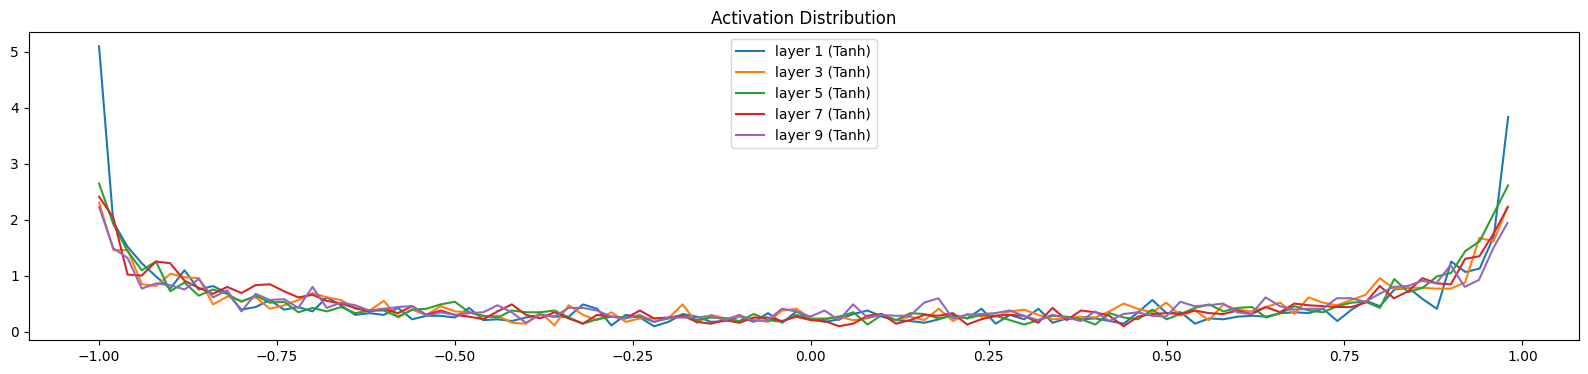

In [15]:
plt.figure(figsize=(20,4))
legends=[]
for i,layer in enumerate(layers[:-1]):
    if isinstance(layer,Tanh):
        t = layer.out
        print('layer %d (%10s): mean %+.2f, std %.2f, saturated %.2f%%' % (i, layer.__class__.__name__, t.mean(), t.std(), (t.abs() > 0.97).float().mean()*100))
        hy,hx = torch.histogram(t, density=True)
        plt.plot(hx[:-1].detach(), hy.detach())
        legends.append(f'layer {i} ({layer.__class__.__name__})')
plt.legend(legends)
plt.title( 'Activation Distribution');

1 (      Tanh): mean -0.0000054, std 3.059084e-03
3 (      Tanh): mean +0.0000371, std 3.085332e-03
5 (      Tanh): mean -0.0000072, std 2.888205e-03
7 (      Tanh): mean +0.0000119, std 2.756316e-03
9 (      Tanh): mean +0.0000071, std 2.337389e-03


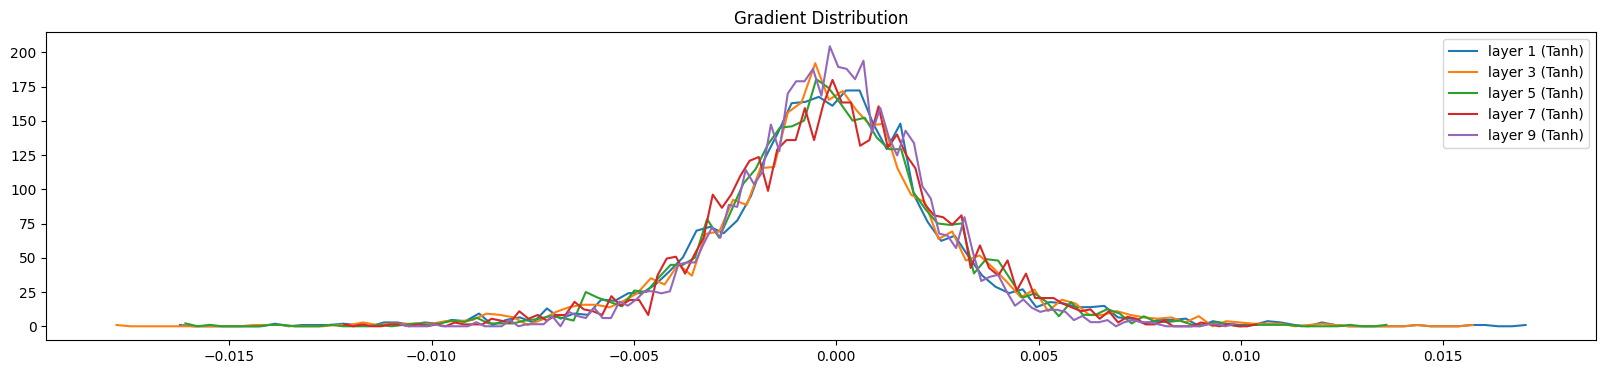

In [16]:
plt.figure(figsize=(20,4))
legends=[]
for i,layer in enumerate(layers[:-1]):
    if isinstance(layer,Tanh):
        t = layer.out.grad
        print ( f'%d (%10s): mean %+.7f, std %e' % (i, layer.__class__.__name__, t.mean(), t.std()))
        hy,hx = torch.histogram(t,density=True)
        plt.plot(hx[:-1].detach(),hy.detach())
        legends.append(f'layer {i} ({layer.__class__.__name__})')
plt.legend(legends)
plt.title('Gradient Distribution');

weight   (27, 10), mean +0.000772, std 9.714616e-03, grad:data ratio 9.714502e-03
weight  (30, 100), mean -0.000036, std 8.734046e-03, grad:data ratio 2.792835e-02
weight (100, 100), mean +0.000085, std 7.424626e-03, grad:data ratio 4.417371e-02
weight (100, 100), mean +0.000055, std 6.242012e-03, grad:data ratio 3.681916e-02
weight (100, 100), mean +0.000007, std 6.161664e-03, grad:data ratio 3.650615e-02
weight (100, 100), mean +0.000069, std 5.221999e-03, grad:data ratio 3.102274e-02
weight  (100, 27), mean +0.000000, std 2.281147e-02, grad:data ratio 3.229574e-01


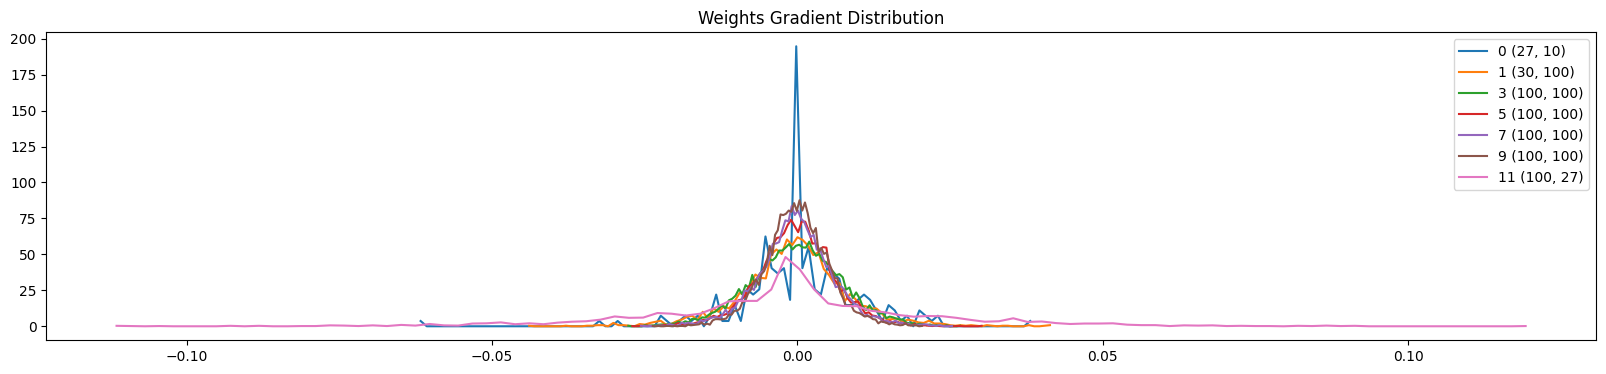

In [17]:
plt.figure(figsize=(20,4))
legends = []
for i,p in enumerate(parameters):
    t = p.grad
    if  p.ndim == 2:
        print ( 'weight %10s, mean %+f, std %e, grad:data ratio %e' % (tuple(p.shape), t.mean(), t.std(), t.std() / p.std()) )
        hy,hx = torch.histogram(t,density=True)
        plt.plot(hx[:-1].detach(), hy.detach())
        legends.append(f'{i} {tuple(p.shape)}')
plt.legend(legends)
plt.title("Weights Gradient Distribution");
               

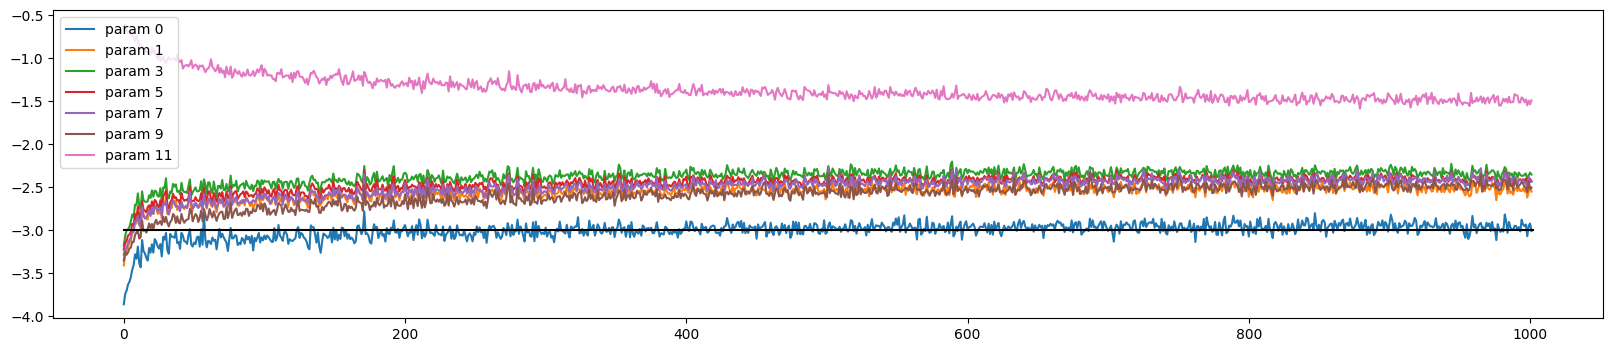

In [18]:
plt.figure(figsize=(20,4))
legends=[]
for i,p in enumerate(parameters):
    if p.ndim == 2:
        plt.plot([ud[j][i] for j in range(len(ud))])
        legends.append('param %d' % i)
plt.plot([0, len(ud)], [-3, -3], 'k')
plt.legend(legends)